In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from dtuimldmtools import *
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
from sklearn.preprocessing import PolynomialFeatures
from dtuimldmtools import rlr_validate

In [143]:
df = pd.read_csv(r'C:\Users\malth\OneDrive - Danmarks Tekniske Universitet\Porgrammering\02445---Individuel-assignment-\HR_data.csv')
df

,Unnamed: 0,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
0,0,77.965186,78.000,3.345290,73.23,83.37,22924.945,round_3,phase3,1,1,1,D1_1
1,1,70.981097,70.570,2.517879,67.12,78.22,21930.400,round_3,phase2,1,1,5,D1_1
2,2,73.371959,73.360,3.259569,67.88,80.22,21647.085,round_3,phase1,1,1,0,D1_1
3,3,78.916822,77.880,4.054595,72.32,84.92,25258.905,round_2,phase3,1,1,1,D1_1
4,4,77.322226,74.550,6.047603,70.52,90.15,23890.565,round_2,phase2,1,1,5,D1_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,163,73.594539,72.380,9.474556,57.43,93.53,21482.985,round_4,phase2,14,0,8,D1_2
164,164,57.839897,54.130,6.796647,52.97,74.14,16825.740,round_4,phase1,14,0,0,D1_2
165,165,64.237295,65.195,3.589241,58.97,72.63,18691.065,round_1,phase3,14,0,1,D1_2
166,166,70.834320,70.440,2.391160,66.65,76.07,20753.005,round_1,phase2,14,0,4,D1_2


In [144]:
features = df[['HR_Mean','HR_Median','HR_std','HR_Min','HR_Max','HR_AUC']]
x_standardized = (features - features.mean()) / features.std()
x = torch.tensor(x_standardized.values, dtype=torch.float32)
y = torch.tensor(df['Frustrated'].values, dtype=torch.long)
groups = df['Individual']
x_standardized

,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC
0,0.260749,0.392342,-0.631771,0.824668,-0.445924,-0.131939
1,-0.670301,-0.524777,-0.825667,-0.042982,-0.849385,-0.409001
2,-0.351575,-0.180394,-0.651859,0.064942,-0.692701,-0.487928
3,0.387612,0.377530,-0.465551,0.695444,-0.324494,0.518262
4,0.175036,-0.033507,0.001493,0.439835,0.085234,0.137066
...,...,...,...,...,...,...
163,-0.321902,-0.301360,0.804569,-1.419009,0.350030,-0.533643
164,-2.422157,-2.554041,0.177024,-2.052351,-1.169020,-1.831071
165,-1.569319,-1.188238,-0.574603,-1.200322,-1.287316,-1.311424
166,-0.689868,-0.540823,-0.855363,-0.109724,-1.017820,-0.737003


### Model 1 ANN

In [ ]:
class ANNClassifier(torch.nn.Module):
    def __init__(self,input_dim, hidden_units, output_dim):
        super(ANNClassifier,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim,hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(hidden_units,output_dim)
        )
    def forward(self,x):
        return self.net(x)
    
#Hyperparameters:
input_dim = x.shape[1]
hidden_units = 132
output_dim = 10

epochs = 5000
learning_rate = 0.001

# Group K-Fold:
gkf = GroupKFold(n_splits=5)
ann_accuracy = []

for train_idx, test_idx in gkf.split(x,y, groups = groups):
    model = ANNClassifier(input_dim,hidden_units,output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = torch.nn.CrossEntropyLoss()

    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss = {loss.item():.4f}")

    #Evaluation of the model:
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_labels = torch.argmax(y_pred,dim = 1)
        acc = accuracy_score(y_test.numpy(), y_pred_labels.numpy())
        ann_accuracy.append(acc)

print(f"ANN Average Accuracy: {np.mean(ann_accuracy):3f}")

KeyboardInterrupt: 


--- Fold 1 ---
Fold 1 | Iteration 500 | Loss: 2.3868 | Train Acc: 0.1136 | Test Acc: 0.2500
Fold 1 | Iteration 500 | Loss: 2.3708 | Train Acc: 0.1212 | Test Acc: 0.2222
Fold 1 | Iteration 500 | Loss: 2.3476 | Train Acc: 0.1439 | Test Acc: 0.1667
Fold 1 | Iteration 500 | Loss: 2.3298 | Train Acc: 0.3030 | Test Acc: 0.1389
Fold 1 | Iteration 500 | Loss: 2.3064 | Train Acc: 0.3030 | Test Acc: 0.1389
Fold 1 | Iteration 500 | Loss: 2.2814 | Train Acc: 0.3030 | Test Acc: 0.1389
Fold 1 | Iteration 500 | Loss: 2.2393 | Train Acc: 0.3030 | Test Acc: 0.1389
Fold 1 | Iteration 500 | Loss: 2.2000 | Train Acc: 0.3030 | Test Acc: 0.1389
Fold 1 | Iteration 500 | Loss: 2.1564 | Train Acc: 0.3030 | Test Acc: 0.1389
Fold 1 | Iteration 500 | Loss: 2.1046 | Train Acc: 0.3030 | Test Acc: 0.1389
Fold 1 | Iteration 500 | Loss: 2.0570 | Train Acc: 0.3030 | Test Acc: 0.1389
Fold 1 | Iteration 500 | Loss: 2.0089 | Train Acc: 0.3030 | Test Acc: 0.1389
Fold 1 | Iteration 500 | Loss: 1.9329 | Train Acc: 0.3030 | 

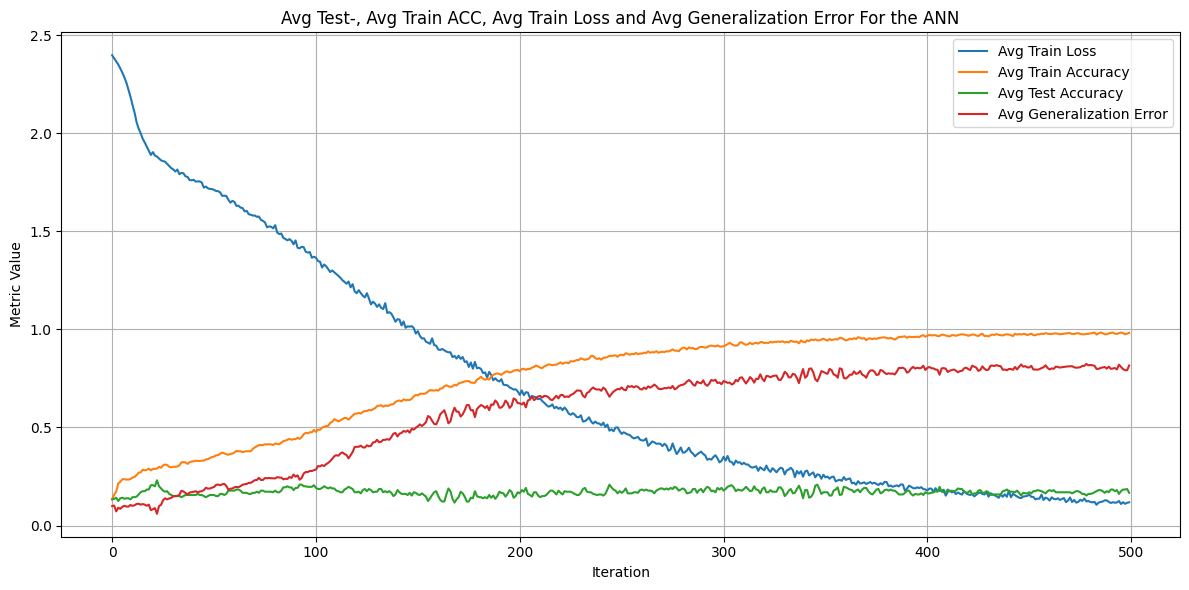


✅ ANN Average Test Accuracy: 0.1667

✅ ANN Average Training Accuracy: 0.7500

✅ ANN Average Generalization Error: 0.5300


In [173]:
class ANNClassifier(torch.nn.Module):
    def __init__(self,input_dim, hidden_units, output_dim):
        super(ANNClassifier,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim,hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(hidden_units,output_dim)
        )
    def forward(self,x):
        return self.net(x)

# Hyperparameters
input_dim = x.shape[1]
hidden_units = 132
output_dim = 11
iteration = 500
learning_rate = 0.001

# Group K-Fold
gkf = GroupKFold(n_splits=5)

# Lists to store metrics per fold
all_train_losses = []
all_train_accuracies = []
all_test_accuracies = []
all_generalization_errors = []
ann_accuracy = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(x, y, groups=groups)):
    print(f"\n--- Fold {fold+1} ---")

    model = ANNClassifier(input_dim, hidden_units, output_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-10)
    criterion = torch.nn.CrossEntropyLoss()

    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    fold_train_losses = []
    fold_train_accuracies = []
    fold_test_accuracies = []
    fold_generalization_errors = []

    for iterations in range(iteration):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            train_preds = model(X_train)
            train_labels = torch.argmax(train_preds, dim=1)
            train_acc = accuracy_score(y_train.numpy(), train_labels.numpy())

            test_preds = model(X_test)
            test_labels = torch.argmax(test_preds, dim=1)
            test_acc = accuracy_score(y_test.numpy(), test_labels.numpy())

        fold_train_losses.append(loss.item())
        fold_train_accuracies.append(train_acc)
        fold_test_accuracies.append(test_acc)
        fold_generalization_errors.append(abs(train_acc - test_acc))

        if iteration % 100 == 0:
            print(f"Fold {fold+1} | Iteration {iteration} | Loss: {loss.item():.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    all_train_losses.append(fold_train_losses)
    all_train_accuracies.append(fold_train_accuracies)
    all_test_accuracies.append(fold_test_accuracies)
    all_generalization_errors.append(fold_generalization_errors)
    ann_accuracy.append(fold_test_accuracies[-1])

# Average metrics over folds
train_losses_avg = np.mean(all_train_losses, axis=0)
train_accuracies_avg = np.mean(all_train_accuracies, axis=0)
test_accuracies_avg = np.mean(all_test_accuracies, axis=0)
generalization_errors_avg = np.mean(all_generalization_errors, axis=0)

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train_losses_avg, label='Avg Train Loss')
plt.plot(train_accuracies_avg, label='Avg Train Accuracy')
plt.plot(test_accuracies_avg, label='Avg Test Accuracy')
plt.plot(generalization_errors_avg, label='Avg Generalization Error')
plt.xlabel('Iteration')
plt.ylabel('Metric Value')
plt.title('Avg Test-, Avg Train ACC, Avg Train Loss and Avg Generalization Error For the ANN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\n✅ ANN Average Test Accuracy: {np.mean(ann_accuracy):.4f}")
print(f"\n✅ ANN Average Training Accuracy: {np.mean(fold_train_accuracies):.4f}")
print(f"\n✅ ANN Average Generalization Error: {np.mean(fold_generalization_errors):.4f}")

### Model 2 Logistic Regression 

In [ ]:
# GroupKFold setup
gkf = GroupKFold(n_splits=5)

# Store metrics
lr_train_accuracies = []
lr_test_accuracies = []
lr_gen_errors = []

# Cross-validation loop
for fold, (train_idx, test_idx) in enumerate(gkf.split(x, y, groups=groups)):
    print(f"\n| Fold {fold+1}|")

    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


    # Updated Logistic Regression model (no deprecated 'multi_class')
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    gen_error = train_acc - test_acc

    # Store metrics
    lr_train_accuracies.append(train_acc)
    lr_test_accuracies.append(test_acc)
    lr_gen_errors.append(gen_error)

    print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Gen Error: {gen_error:.4f}")

# Report averages
avg_train_acc = np.mean(lr_train_accuracies)
avg_test_acc = np.mean(lr_test_accuracies)
avg_gen_error = np.mean(lr_gen_errors)

print("\n Logistic Regression Summary (GroupKFold):")
print(f"Average Train Accuracy: {avg_train_acc:.4f}")
print(f"Average Test Accuracy: {avg_test_acc:.4f}")
print(f"Average Gen Error: {avg_gen_error:.4f}")



| Fold 1|
Train Acc: 0.3333 | Test Acc: 0.1111 | Gen Error: 0.2222

| Fold 2|
Train Acc: 0.3258 | Test Acc: 0.2222 | Gen Error: 0.1035

| Fold 3|
Train Acc: 0.3258 | Test Acc: 0.1389 | Gen Error: 0.1869

| Fold 4|
Train Acc: 0.3182 | Test Acc: 0.1944 | Gen Error: 0.1237

| Fold 5|
Train Acc: 0.3125 | Test Acc: 0.2917 | Gen Error: 0.0208

 Logistic Regression Summary (GroupKFold):
Average Train Accuracy: 0.3231
Average Test Accuracy: 0.1917
Average Gen Error: 0.1314
